In [13]:
using JLD
using PyPlot
using Statistics, StatsBase
using Clustering
using Distances  # Este es necesario para hacer la matriz de distancia, es complemento a Clustering.

In [14]:
push!(LOAD_PATH, "../Preprocesamiento/")
using ArraySetTools # pa aprovechar las cosas que ya tenemos.

In [15]:
function normalizar1(xx::Array)
    norma=maximum(abs.(xx))
    result=xx./norma
    return result
end

normalizar1 (generic function with 1 method)

In [16]:
function filtraclusterchicos(puntos::Array, clustree, umbral)
    tabla=hcat(puntos,clustree)
    valores=unique(clustree)
    dd=Dict([(i,count(x->x==i,clustree)) for i in valores])
    predicado(j)=dd[j]>umbral
    result=tabla[map(x->predicado(x), clustree),:]
    (clusterfuck, cual)=findmax(dd)
    println("el cluster mayor tiene ",clusterfuck, " elementos, es el ", cual)
    return result
end

function filtraclusterchicos(puntos::Dict, umbral)
    # no solo aqui ya estan separados por dicctionario, sino tambien
    # en "electrodos", es decir numeros enteros
   result=Dict{Int, Set}()
    for k in keys(puntos)
        if length(puntos[k])>umbral
            result[k]=puntos[k]
        end
    end
    return result
end

filtraclusterchicos (generic function with 2 methods)

In [17]:


function declustaset(puntosyclust::Array; enteros=true)
    #= la funcion convierte el cluster en una tabla
    a un conjunto de enteros, sobre una malla 
    =#
    
    result=Dict{Int,Set}()
    clustnames=unique(puntosyclust[:,end])
    
    for q in clustnames
        subt=puntosyclust[puntosyclust[:,end].==q,:]
       if enteros
            punt=rowstoset(round.(Int64,subt[:,1:end-1]))
        else
            punt=rowstoset(subt[:,1:end-1], enteros=enteros)
        end    
        qindez=round(Int64,q)
        result[qindez]=punt
    end
    return result

end



declustaset (generic function with 1 method)

In [18]:
#funcion solo para plotear, no se si luego la vas a usar.
function dictatabla(dict::Dict; ancho=4, una=true)
    # si una, entonces todo va en una tabla, si no, va en tablitas separadas
    
    
    if una 
        aux=zeros(1,ancho+1)
    else
        aux=Dict{Any, Any}()
    end
    
    for q in keys(dict)
        
        aux2=zeros(1,ancho)
        
        for renglon in dict[q]
            aux2=vcat(aux2, renglon)
         
        end
        
      
        
        aux2=aux2[2:end,:]
        
        (l,k)=size(aux2)
        columnaextra=ones(Int64, l).*q
        aux3=hcat(aux2, columnaextra)
        
        
        
        if una
            aux=vcat(aux, aux3)
        else
            aux[q]=aux2
        end
    end
    
    if una
        return aux[2:end,:]
    else
        return aux
    end
end


dictatabla (generic function with 1 method)

In [19]:
nombrecm="/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_prepro-CM.jld"
archivo=load(nombrecm)
DatosCMP=archivo["CMP"]
DatosCMN=archivo["CMN"];
evocada=false
nmax=length(DatosCMP)

2000

In [20]:
# Datos ordenados 4dimensionalmente.
# vamos a usar masa maxima y tiempo maximo normalizados a 64 (dist max.)
# para hacer un hipercubo platonico y hacer el apiñonamiento jerárquico ahi.

fruncio=Array{Float64}(undef, 0,4)

for k in keys(DatosCMP)
    dat=DatosCMP[k]
    (alto, ancho)=size(dat)
    auxt=ones(alto).*k
    afafa=hcat(dat, auxt)
    fruncio=vcat(fruncio,afafa)
end

fruncio=fruncio[sortperm(fruncio[:, 4]), :];

In [21]:
masamax=maximum(fruncio[:,3])

12329.550282478333

In [22]:
nmax=maximum(fruncio[:,4])

2000.0

In [23]:
function plot4Ddiscs(datos::Array; escala=0.05)
    figure(figsize=(8,6.5))
    
    xx=datos[:,1]
    yy=datos[:,2]
    gordis=datos[:,3]
    nn=datos[:,4]
    
    xlim(0.0,65.0)
    ylim(0.0,65.0)
    
    
    scatter(xx,yy, s=escala*gordis, edgecolors="darkmagenta", c=nn, cmap="plasma", lw=0.5)
    colorbar()
    show()
end


plot4Ddiscs (generic function with 1 method)

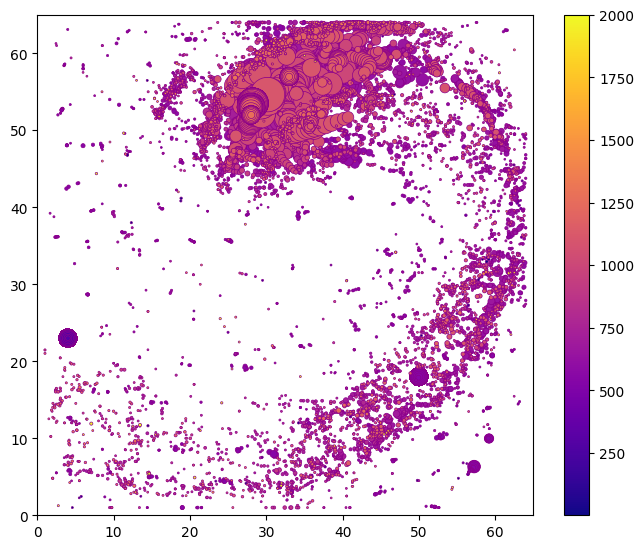

In [24]:
fig=plot4Ddiscs(fruncio)


In [25]:
histogordis=fit(Histogram, fruncio[:,3], 1:20:5001)

Histogram{Int64,1,Tuple{StepRange{Int64,Int64}}}
edges:
  1:20:5001
weights: [0, 386, 2840, 1481, 885, 491, 324, 242, 178, 162  …  1, 3, 3, 1, 3, 3, 1, 1, 3, 0]
closed: left
isdensity: false

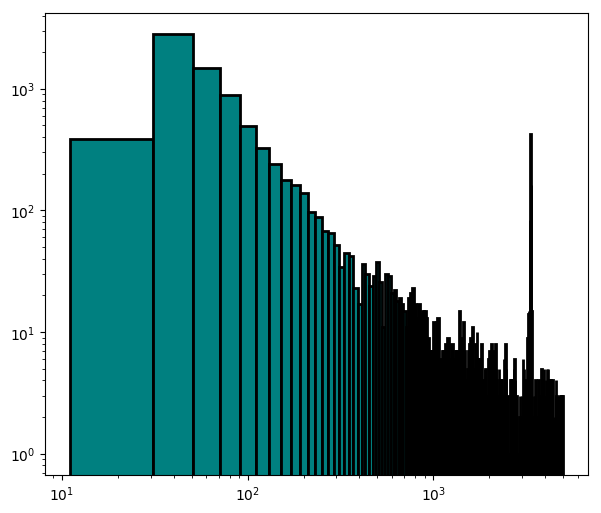

In [26]:
#histogordis.weights
figure(figsize=(7,6))
bar(histogordis.edges[1][1:end-1], histogordis.weights, width=20, 
    color="teal", edgecolor="k", linewidth=2)
yscale("log")
xscale("log")
show()

In [27]:
gmin=nquantile(fruncio[:,3], 10)[2]

44.147528648376465

In [28]:
frunciofiltrado=fruncio[fruncio[:,3].>gmin,:]
size(frunciofiltrado)

(8856, 4)

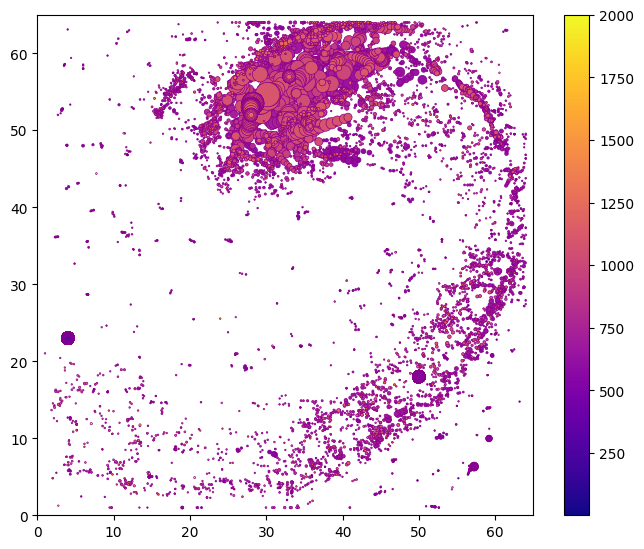

In [29]:
plot4Ddiscs(frunciofiltrado, escala=0.025)


In [30]:
# clust1=fruncio[:,1:2];
clust1=permutedims(frunciofiltrado)

4×8856 Array{Float64,2}:
 46.7927  27.3672   30.7173  55.1767   …    24.1639    11.3209     2.75101
 54.6672   4.15315  56.2334   4.80699       14.6006    49.6291     1.24794
 45.3749  63.8133   46.5284  47.0146        56.2697    64.1216    45.5731 
  1.0      1.0       1.0      1.0         2000.0     2000.0     2000.0    

In [31]:
clust1[3,:]=normalizar1(clust1[3,:]).*64
clust1[4,:]=normalizar1(clust1[4,:]).*64;

In [32]:
clustspaciotiempo=vcat(clust1[1:2,:], transpose(clust1[4,:]))

3×8856 Array{Float64,2}:
 46.7927  27.3672   30.7173  55.1767   …  60.5552  24.1639  11.3209   2.75101
 54.6672   4.15315  56.2334   4.80699     57.4671  14.6006  49.6291   1.24794
  0.032    0.032     0.032    0.032       64.0     64.0     64.0     64.0    

In [33]:
# decisiones, decisiones
dd4d=pairwise(Euclidean(), clust1, dims=2);
dd3d=pairwise(Euclidean(), clustspaciotiempo, dims=2);
dd2d=pairwise(Euclidean(), clust1[1:2,:], dims=2);

In [34]:
function scatterclust(puntos, clustn)

fafa=figure(figsize=(4,4))
#axis("equal")

xlim(0.0,65.0)
ylim(0.0,65.0)
scatter(puntos[:,1],puntos[:,2], s=0.5, c=clustn, cmap="inferno")
colorbar(fraction=0.045)
end

scatterclust (generic function with 1 method)

# Aquí abajo esta DBSCAN


In [112]:
db3d=dbscan(dd3d, 2, 6)

DbscanResult([7, 18, 361, 435, 447, 472, 539, 591, 640, 657  …  7597, 7659, 7847, 7915, 8290, 8346, 8362, 8632, 8676, 8740], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [295, 7, 288, 16, 6, 13, 9, 6, 6, 9  …  7, 28, 7, 6, 8, 27, 6, 9, 7, 7])

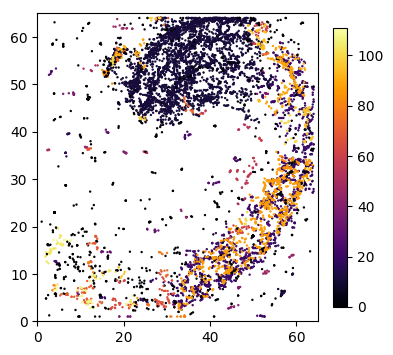

PyObject <matplotlib.colorbar.Colorbar object at 0x7f7129693240>

In [113]:
scatterclust(frunciofiltrado, db3d.assignments)

In [114]:
aver=count(x->x==0, db3d.assignments)

976

In [115]:
la=length(unique(db3d.assignments))

112

In [116]:
tamgrups=fit(Histogram, db3d.assignments, 0:la)

Histogram{Int64,1,Tuple{UnitRange{Int64}}}
edges:
  0:112
weights: [976, 295, 7, 288, 16, 6, 13, 9, 6, 6  …  7, 28, 7, 6, 8, 27, 6, 9, 7, 7]
closed: left
isdensity: false

In [117]:
ordenado=sortperm(tamgrups.weights, rev=true);
tamgrups.edges[1][1:end-1]

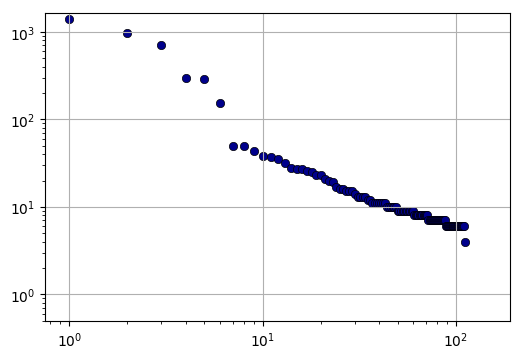

In [119]:
#histogordis.weights
figure(figsize=(6,4))

ylim(0.5,aver*1.7)
xlim(0.75,la*1.7)
#bar(tamgrups.edges[1][1:end-1], tamgrups.weights[ordenado], width=1, 
#    color="darkblue", edgecolor="k", linewidth=1)
scatter(tamgrups.edges[1][1:end-1], tamgrups.weights[ordenado], 
    color="darkblue", edgecolor="k", linewidth=0.5)

yscale("log")
xscale("log")
grid()
#show()

In [120]:
using LsqFit

┌ Info: Recompiling stale cache file /home/karel/.julia/compiled/v1.0/LsqFit/GCdY9.ji for LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1190


In [121]:
@. model(x,p)=p[1]*x^p[2]

model (generic function with 1 method)

In [138]:
xdata=tamgrups.edges[1][2:end];
ydata=tamgrups.weights[ordenado];
p0 = [aver, -0.5]
lw=[aver*0.5, -10]
up=[aver*2, -0.1]

2-element Array{Float64,1}:
 1952.0
   -0.1

In [139]:
size(xdata), size(ydata)

((112,), (112,))

In [140]:
firit = curve_fit(model, xdata, ydata, p0, lower=lw, upper=up)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Int64,1}}([1952.0, -1.59969], [-1782.0, -773.944, -639.309, -492.496, -146.289, -176.91, -66.1877, 20.1152, 9.07427, 5.06658  …  -4.8236, -4.84164, -4.85924, -4.8764, -4.89316, -4.9095, -4.92546, -4.94105, -4.95627, -2.97114], [1.0 0.0; 0.329947 446.426; … ; 0.000534698 4.91548; 0.000527082 4.85469], false, Int64[])

In [141]:
firit.param

2-element Array{Float64,1}:
 1952.0             
   -1.59969406882503

In [142]:
faux(x)=model(x, firit.param)

faux (generic function with 1 method)

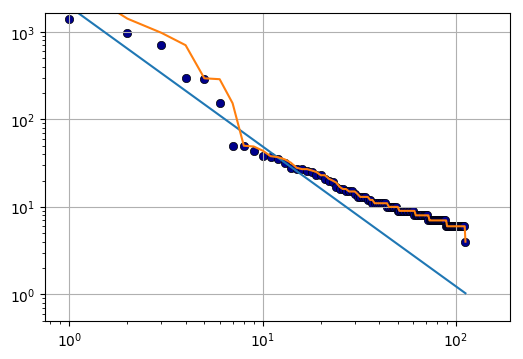

In [145]:
histogordis.weights
figure(figsize=(6,4))

ylim(0.5,aver*1.7)
xlim(0.75,la*1.7)
#bar(tamgrups.edges[1][1:end-1], tamgrups.weights[ordenado], width=1, 
#    color="darkblue", edgecolor="k", linewidth=1)
scatter(tamgrups.edges[1][1:end-1], tamgrups.weights[ordenado], 
    color="darkblue", edgecolor="k", linewidth=0.5)
plot(xdata, faux.(xdata))
plot(xdata, ydata)

yscale("log")
xscale("log")
grid()

# Aqui abajo esta el Jerarquico.

In [28]:
h4d=hclust(dd4d)
h3d=hclust(dd3d)
h2d=hclust(dd2d)

Hclust{Float64}([-137 -154; -32 -317; … ; 5286 8853; 4636 8854], [9.36836e-6, 1.08421e-5, 2.18722e-5, 2.27687e-5, 2.388e-5, 2.38943e-5, 2.3937e-5, 2.90832e-5, 3.26346e-5, 3.26485e-5  …  3.89438, 3.93271, 4.08506, 4.10886, 4.23181, 4.28125, 4.37309, 4.37604, 4.53162, 4.92297], [956, 1200, 1037, 1116, 2414, 2429, 2450, 1068, 1234, 1298  …  1181, 1256, 1319, 1279, 1130, 838, 873, 919, 991, 1076], :single)

In [128]:
hcorta=0.333 #estrictamente mas
clust4d=cutree(h4d,h=hcorta)
clust3d=cutree(h3d,h=hcorta)
clust2d=cutree(h2d,h=hcorta);

In [129]:
size(unique(clust4d))

(5265,)

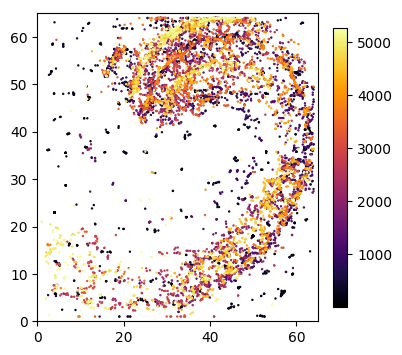

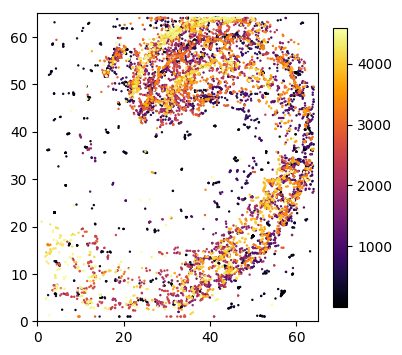

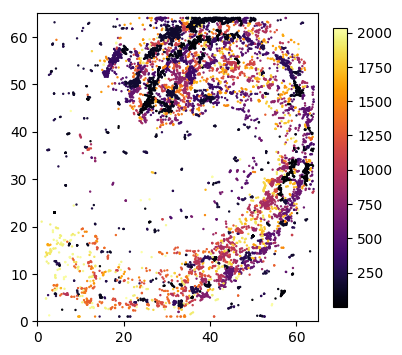

PyObject <matplotlib.colorbar.Colorbar object at 0x7fb98732b4a8>

In [131]:
scatterclust(frunciofiltrado, clust4d)
scatterclust(frunciofiltrado, clust3d)
scatterclust(frunciofiltrado,clust2d)

In [210]:
temp=hcat(frunciofiltrado, db2d.assignments)
dict2d=declustaset(temp, enteros=false)
blabla2d=filtraclusterchicos(dict2d, 20);

In [211]:
length(keys(blabla2d))

24

In [212]:

for k in keys(blabla2d)
    l=length(blabla2d[k])
    println(" el grupo $k tiene $l elementos para regiones de Sources")
 end



 el grupo 18 tiene 264 elementos para regiones de Sources
 el grupo 54 tiene 178 elementos para regiones de Sources
 el grupo 81 tiene 26 elementos para regiones de Sources
 el grupo 2 tiene 26 elementos para regiones de Sources
 el grupo 143 tiene 29 elementos para regiones de Sources
 el grupo 16 tiene 284 elementos para regiones de Sources
 el grupo 91 tiene 21 elementos para regiones de Sources
 el grupo 134 tiene 25 elementos para regiones de Sources
 el grupo 0 tiene 646 elementos para regiones de Sources
 el grupo 9 tiene 21 elementos para regiones de Sources
 el grupo 25 tiene 25 elementos para regiones de Sources
 el grupo 7 tiene 235 elementos para regiones de Sources
 el grupo 66 tiene 149 elementos para regiones de Sources
 el grupo 83 tiene 61 elementos para regiones de Sources
 el grupo 17 tiene 315 elementos para regiones de Sources
 el grupo 8 tiene 31 elementos para regiones de Sources
 el grupo 4 tiene 295 elementos para regiones de Sources
 el grupo 53 tiene 55 eleme

In [219]:
  punchis=[0 0 0 0]
for k in (0,)
    punchis=[0 0 0 0]
    for h in dict2d[k]
        punchis=vcat(punchis, h)
    end
end

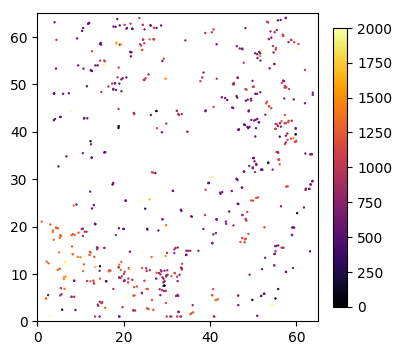

PyObject <matplotlib.colorbar.Colorbar object at 0x7fb985b25be0>

In [220]:

fafa=figure(figsize=(4,4))
#axis("equal")

xlim(0.0,65.0)
ylim(0.0,65.0)
scatter(punchis[:,1],punchis[:,2], s=0.5,c=punchis[:,4], cmap="inferno")
colorbar(fraction=0.045)

In [198]:
blatabla3d=dictatabla(blabla2d);
#buf=dictatabla(blabla3d, una=false)

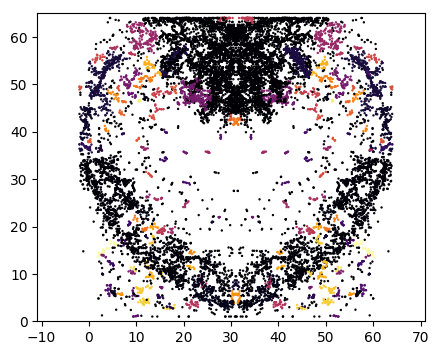

In [201]:
fafa=figure(figsize=(5,4))

#ax=gca()
#ax.set_facecolor("k")
axis("equal")

xlim(-5.0,65.0)
ylim(0.0,65.0)
scatter(blatabla3d[:,1], blatabla3d[:,2], c=blatabla3d[:,5], s=0.5, cmap="inferno")
scatter((-1).*blatabla3d[:,1].+62, blatabla3d[:,2], c=blatabla3d[:,5], s=0.5, cmap="inferno")

show()
#colorbar()

In [150]:
unique(blatabla[:,3])

UndefVarError: UndefVarError: blatabla not defined

In [ ]:
using QHull

In [ ]:
convexas=Dict{Any, Any}()
for k in keys(buf)
    puf =buf[k]
    print(k, " ")
    ch = chull(puf)
    convexas[k]=ch
end

In [ ]:
poly=PyPlot.matplotlib.patches.Polygon
appnplot=PyPlot.matplotlib.patches
colect=matplotlib.collections.PatchCollection

In [ ]:
keys(colect)

In [ ]:
orderhull=Dict{Any, Any}()
for k in keys(convexas)
    plaf=[0 0]
    for j in convexas[k].vertices
        aux=transpose(convexas[k].points[j,:])
        plaf=vcat(plaf, aux)
    end
    orderhull[k]=plaf[2:end,:]
end

In [ ]:
f=figure(figsize=(6,6))
fig, ax = plt.subplots()
popo=[]
for k in values(orderhull)
    punch=poly(k, true)
    push!(popo, punch)
end
cucu=colect(popo, alpha=0.5)
cucu.set_array(1:50)
ax.add_collection(cucu)
fig.colorbar(cucu, ax=ax)

#savefig("tuabuela.png", dpi=92)
show(f)